### Prepare imports

In [75]:
import json
from pathlib import Path
from typing import Tuple, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.pylabtools import figsize
from matplotlib.path import Path as MplPath

from pix2lv95 import apply_transform_to_points, fit_pixel_to_lv95_transform

### Load and consolidate both csv into one dataframe

In [76]:
start_time = pd.Timestamp('2025-10-08 18:00:00')
df1 = pd.read_csv('../outputs/pipeline_run/tracks_video_3_24fps.csv')
df2 = pd.read_csv('../outputs/pipeline_run/tracks_video_4_24fps.csv')
df2['frame'] = df1['frame'].max() + 2 + df2['frame']
df2['tracker_id'] = df2['tracker_id'] + df1['tracker_id'].max()
df_track = pd.concat([df1, df2], ignore_index=True)
df_track['second'] = df_track['frame'] / 24
df_track['timestamp'] = start_time + pd.to_timedelta(df_track['second'], unit='s')
df_track

,x_min,y_min,x_max,y_max,class_id,confidence,tracker_id,class_name,frame,lv95_E,lv95_N,second,timestamp
0,396.500760,265.317500,435.22174,298.09340,3,0.893168,1,car,0,2680856.5,1248087.4,0.00,2025-10-08 18:00:00.000
1,252.669200,173.365300,301.66050,211.91098,3,0.890062,2,car,0,2680842.8,1248096.2,0.00,2025-10-08 18:00:00.000
2,585.264700,390.093350,627.72100,426.62076,3,0.888664,3,car,0,2680875.8,1248074.6,0.00,2025-10-08 18:00:00.000
3,94.042244,70.888960,137.00345,103.67353,3,0.883950,4,car,0,2680826.5,1248106.8,0.00,2025-10-08 18:00:00.000
4,325.405850,214.854640,369.85947,250.86885,3,0.881080,5,car,0,2680849.8,1248092.2,0.00,2025-10-08 18:00:00.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300322,215.017790,194.584150,258.00630,229.92828,3,0.594776,7295,car,63102,2680848.5,1248092.0,2629.25,2025-10-08 18:43:49.250
300323,103.368310,119.855960,146.78412,154.12160,3,0.845623,7321,car,63102,2680837.2,1248099.5,2629.25,2025-10-08 18:43:49.250
300324,0.475049,52.168625,46.88651,88.06561,3,0.896018,7373,car,63102,2680827.0,1248106.2,2629.25,2025-10-08 18:43:49.250
300325,450.436300,366.733000,495.75778,405.69757,3,0.897785,7086,car,63102,2680872.0,1248074.6,2629.25,2025-10-08 18:43:49.250


In [77]:
def compute_flow_events(df_track, line_coords):
    """
    Detects first crossing per tracker across an LV95 line segment.
    Returns events_df with ['tracker_id','timestamp','x_cross','y_cross','direction'].
    """
    x1, y1 = line_coords[0]
    x2, y2 = line_coords[1]

    def side(x, y):
        return (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)

    def seg_inter(xa, ya, xb, yb, xc, yc, xd, yd, eps=1e-9):
        den = (xb - xa) * (yd - yc) - (yb - ya) * (xd - xc)
        if abs(den) < eps:
            return None
        ua = ((xc - xa) * (yd - yc) - (yc - ya) * (xd - xc)) / den
        vb = ((xc - xa) * (yb - ya) - (yc - ya) * (xb - xa)) / den
        if -eps <= ua <= 1 + eps and -eps <= vb <= 1 + eps:
            xi = xa + ua * (xb - xa)
            yi = ya + ua * (yb - ya)
            return ua, xi, yi
        return None

    ev = []
    # IMPORTANT: rely on your real timestamps; no fps assumptions needed
    for tid, g in df_track.sort_values(["tracker_id", "timestamp"]).groupby("tracker_id", sort=False):
        xs = g["lv95_E"].to_numpy()
        ys = g["lv95_N"].to_numpy()
        ts = pd.to_datetime(g["timestamp"]).to_numpy()
        svals = side(xs, ys)
        for i in range(len(xs) - 1):
            hit = seg_inter(xs[i], ys[i], xs[i + 1], ys[i + 1], x1, y1, x2, y2)
            if hit is not None:
                ua, xi, yi = hit
                t_cross = ts[i] + (ts[i + 1] - ts[i]) * ua
                s1, s2 = svals[i], svals[i + 1]
                direction = 1 if (s1 < 0 and s2 > 0) else (-1 if (s1 > 0 and s2 < 0) else np.sign(s2 - s1))
                ev.append((tid, pd.Timestamp(t_cross), xi, yi, int(direction)))
                break  # one crossing per vehicle

    events_df = pd.DataFrame(ev, columns=["tracker_id", "timestamp", "x_cross", "y_cross", "direction"])
    return events_df.sort_values("timestamp").reset_index(drop=True)


def flow_series_resample_ready(events_df, start=None, end=None, base_freq="1S"):
    """
    Produces a zero-filled count series at base_freq that you can resample later.
    Returns a DataFrame indexed by time with:
      - count : crossings per base_freq bin
      - veh_per_hour : rate normalized to veh/h for that bin length
    """
    if events_df.empty:
        idx = pd.date_range(start=start, end=end, freq=base_freq) if (start and end) else pd.DatetimeIndex([],
                                                                                                           name="timestamp")
        out = pd.DataFrame({"count": 0}, index=idx)
        out["veh_per_hour"] = 0.0
        return out

    # define timeline
    t_min = events_df["timestamp"].min() if start is None else pd.Timestamp(start)
    t_max = events_df["timestamp"].max() if end is None else pd.Timestamp(end)
    # bin edges are inclusive of start; make sure we cover the last event
    timeline = pd.date_range(t_min.floor(base_freq), t_max.ceil(base_freq), freq=base_freq)

    # point process → counts at base frequency
    counts = (events_df
              .set_index("timestamp")
              .assign(one=1)
              .resample(base_freq)["one"]
              .sum()
              .reindex(timeline, fill_value=0)
              .rename("count")
              .to_frame())

    # convert counts to veh/h for the base bin size
    bin_seconds = pd.Timedelta(base_freq).total_seconds()
    counts["veh_per_hour"] = counts["count"] * (3600.0 / bin_seconds)
    return counts


def resample_flow(flow_base, rule):
    """
    Aggregates the base series to a coarser rule (e.g., '5min', '15min').
    Returns both raw counts and veh/h for the coarser bin.
    """
    # sum counts in the new bin, then compute veh/h with the new bin length
    out = flow_base["count"].resample(rule).sum().to_frame()
    bin_seconds = pd.Timedelta(rule).total_seconds()
    out["veh_per_hour"] = out["count"] * (3600.0 / bin_seconds)
    return out


In [78]:
# Your LV95 line
line_lv95 = ((2680876.24, 1248069.47), (2680880.04, 1248074.27))

# 1) Detect event timestamps
events_df = compute_flow_events(df_track, line_lv95)

# 2) Build a 1-second base series with zeros everywhere
flow_base_1s = flow_series_resample_ready(events_df, base_freq="1s")

# 3) Resample whenever you need (no recompute)
flow_5min = resample_flow(flow_base_1s, "5min")
flow_15min = resample_flow(flow_base_1s, "15min")
flow_5min

,count,veh_per_hour
2025-10-08 18:00:00,20,240.0
2025-10-08 18:05:00,30,360.0
2025-10-08 18:10:00,28,336.0
2025-10-08 18:15:00,36,432.0
2025-10-08 18:20:00,22,264.0
2025-10-08 18:25:00,26,312.0
2025-10-08 18:30:00,21,252.0
2025-10-08 18:35:00,3,36.0
2025-10-08 18:40:00,4,48.0


In [79]:
roi_pix_path = Path('../data/roi_coordinates.json')
gcp_path = Path('../data/gcp.txt')
roi_pix = json.loads(roi_pix_path.read_text())
gcp = json.loads(gcp_path.read_text())

T_pix2lv95 = fit_pixel_to_lv95_transform(gcp, method="homography")
print(f"Transform type: {T_pix2lv95['type']}, reprojection RMSE: {T_pix2lv95['rmse']:.3f} m")

roi_lv95 = apply_transform_to_points(roi_pix, T_pix2lv95)

Path("../data/roi_lv95.json").write_text(json.dumps(roi_lv95.tolist(), indent=2))

geojson = {
    "type": "Feature",
    "properties": {"name": "ROI (LV95)"},
    "geometry": {"type": "Polygon", "coordinates": [roi_lv95.tolist() + [roi_lv95[0].tolist()]]}
}
Path("roi_lv95.geojson").write_text(json.dumps(geojson, indent=2))
print("Wrote roi_lv95.json and roi_lv95.geojson")

Transform type: H, reprojection RMSE: 3.137 m
Wrote roi_lv95.json and roi_lv95.geojson


In [80]:
# Approximate road length along main axis of ROI (meters)
roi = roi_lv95  # (N x 2) E,N
cent = roi.mean(axis=0)
U, S, Vt = np.linalg.svd(roi - cent, full_matrices=False)
axis = Vt[0]  # principal direction (unit)

# project vertices to this axis
projs = (roi - cent) @ axis
L_m = float(projs.max() - projs.min())
L_km = L_m / 1000.0
print(f"Approximate ROI road length: {L_m:.1f} m  ({L_km:.4f} km)")

Approximate ROI road length: 51.1 m  (0.0511 km)


In [81]:
def density_series_resample_ready(
        df_track: pd.DataFrame,
        roi_lv95: np.ndarray,
        L_km: float,
        base_freq: str = "1s",
        start: Optional[pd.Timestamp] = None,
        end: Optional[pd.Timestamp] = None,
) -> pd.DataFrame:
    from matplotlib.path import Path as MplPath

    if L_km <= 0:
        raise ValueError("L_km must be > 0.")

    df = df_track.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Build base timeline (for zero-filling later)
    t_min = df["timestamp"].min() if start is None else pd.Timestamp(start)
    t_max = df["timestamp"].max() if end is None else pd.Timestamp(end)
    timeline = pd.date_range(t_min.floor(base_freq), t_max.ceil(base_freq), freq=base_freq)

    # --- KEY CHANGE: use pd.Grouper instead of groupby(...).resample(...)
    # One sample per tracker per base bin (last known pos in bin)
    snap = (df
            .sort_values(["tracker_id", "timestamp"])
            .groupby(["tracker_id", pd.Grouper(key="timestamp", freq=base_freq)], as_index=False)
            .last())
    # snap columns now include: ['tracker_id','timestamp','lv95_E','lv95_N', ...]

    # Point-in-polygon
    roi_path = MplPath(roi_lv95)
    pts = snap[["lv95_E", "lv95_N"]].to_numpy()
    snap["inside"] = roi_path.contains_points(pts)

    # Count unique vehicles inside ROI per bin → veh_count
    counts = (snap[snap["inside"]]
              .groupby("timestamp")["tracker_id"]
              .nunique()
              .rename("veh_count")
              .reindex(timeline, fill_value=0)
              .to_frame())

    counts["density_veh_per_km"] = counts["veh_count"] / L_km
    return counts

In [82]:
def combine_flow_density_to_speed(
        flow_base: pd.DataFrame,  # from flow_series_resample_ready(...), columns: ['count','veh_per_hour']
        density_base: pd.DataFrame,
        # from density_series_resample_ready(...), columns: ['veh_count','density_veh_per_km']
        resample_rule: Optional[str] = None
) -> pd.DataFrame:
    """
    Joins base series on time and (optionally) resamples to a coarser interval.
    Output columns:
      - flow_count, flow_veh_per_hour
      - veh_count (inside ROI), density_veh_per_km
      - speed_kmh_est = flow_veh_per_hour / density_veh_per_km
    """
    # Align indexes & names
    f = flow_base.rename(columns={"count": "flow_count", "veh_per_hour": "flow_veh_per_hour"})
    k = density_base.copy()

    df = f.join(k, how="outer").fillna(0)

    # Optional final resample (recommended: mean for rates, sum for counts)
    if resample_rule:
        # counts should be summed; rates should be averaged over the interval
        agg = {
            "flow_count": "sum",
            "flow_veh_per_hour": "mean",
            "veh_count": "sum",
            "density_veh_per_km": "mean",
        }
        df = df.resample(resample_rule).agg(agg)

        # After resampling, you can also recompute flow_veh_per_hour from summed counts if preferred:
        bin_seconds = pd.Timedelta(resample_rule).total_seconds()
        df["flow_veh_per_hour"] = df["flow_count"] * (3600.0 / bin_seconds)

    # Compute speed (km/h): q/k, guard divide-by-zero
    df["speed_kmh_est"] = df["flow_veh_per_hour"] / df["density_veh_per_km"].replace(0, np.nan)
    return df

In [83]:
# 1) FLOW (you already have this)
events_df = compute_flow_events(df_track, line_lv95)
flow_base_1s = flow_series_resample_ready(events_df, base_freq="1s")

# 2) DENSITY (resampleable base series)
density_base_1s = density_series_resample_ready(df_track, roi_lv95, L_km, base_freq="1s")

# 3) Combine and (optionally) resample to, say, 5 minutes
combined_1s = combine_flow_density_to_speed(flow_base_1s, density_base_1s, resample_rule=None)
combined_5min = combine_flow_density_to_speed(flow_base_1s, density_base_1s, resample_rule="5min")

combined_5min.head()

,flow_count,flow_veh_per_hour,veh_count,density_veh_per_km,speed_kmh_est
2025-10-08 18:00:00,20.0,240.0,1084,70.754971,3.391988
2025-10-08 18:05:00,30.0,360.0,938,61.225242,5.879928
2025-10-08 18:10:00,28.0,336.0,663,43.275411,7.764224
2025-10-08 18:15:00,36.0,432.0,773,50.455343,8.562027
2025-10-08 18:20:00,22.0,264.0,1182,77.151638,3.421833


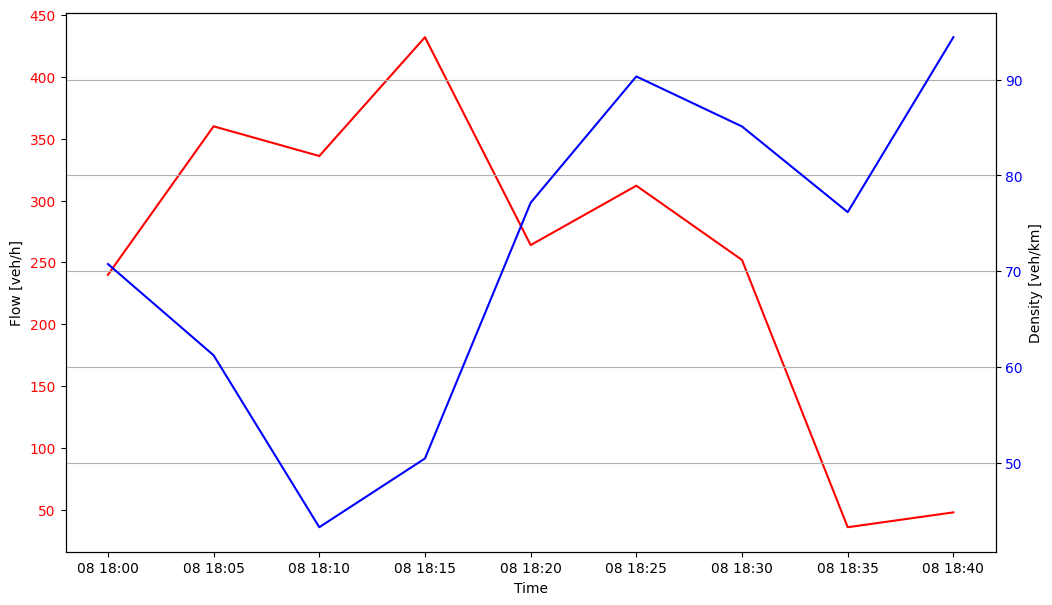

In [84]:
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.set_xlabel('Time')
ax1.set_ylabel('Flow [veh/h]')
ax1.plot(combined_5min['flow_veh_per_hour'], color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()

ax2.set_ylabel('Density [veh/km]')
ax2.plot(combined_5min['density_veh_per_km'], color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.grid()

plt.show()

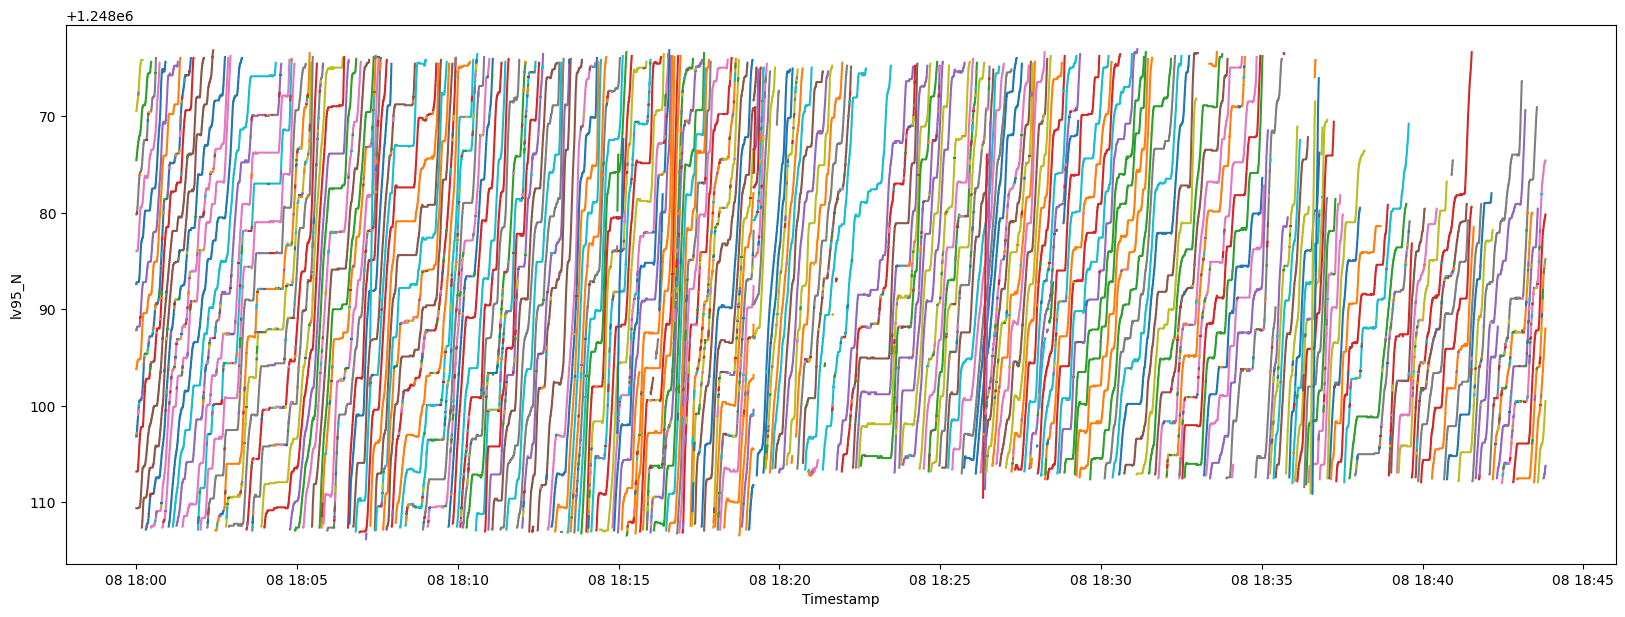

In [91]:
fig = plt.figure(figsize=(20, 7))
for tracker_id, group in df_track.groupby('tracker_id'):
    plt.plot(group['timestamp'], group['lv95_N'], label=f'Track {tracker_id}')
plt.xlabel('Timestamp')
plt.ylabel('lv95_N')
plt.gca().invert_yaxis()  # Reverse the y-axis
plt.show()